In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras import models
import numpy as np
import matplotlib.pyplot as plt

In [7]:
(train_data, train_label), (test_data, test_label) = keras.datasets.boston_housing.load_data()
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [8]:
# Normalize dataset
mean = train_data.mean(axis=0)
train_data -= mean
test_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data /= std

In [10]:
def build_model():
    model = models.Sequential([
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1,),
    ])
    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics=['mae']
    )
    return model

In [25]:
# because we have less data, we have to use k-fold validation for evaluation
k = 4
num_val_samples = len(train_data) // k
epochs = 20
loss_data = []
for i in range(k):
    x_val = train_data[i*num_val_samples: (i+1)*num_val_samples]
    y_val = train_label[i*num_val_samples: (i+1)*num_val_samples]
    xp_data = np.concatenate([
        train_data[: i * num_val_samples],
        train_data[(i+1) * num_val_samples:],
    ], axis=0)
    yp_data = np.concatenate([
        train_label[: i * num_val_samples],
        train_label[(i+1) * num_val_samples:],
    ], axis=0)
    model = build_model()
    model.fit(
        xp_data,
        yp_data,
        epochs=10,
        batch_size=64
    )
    mse, mae = model.evaluate(x_val, y_val)
    loss_data.append(mae)

Epoch 1/10
5/5 [==============================] - 0s 1ms/step - loss: 579.0040 - mae: 22.3770
Epoch 2/10
5/5 [==============================] - 0s 1ms/step - loss: 542.0764 - mae: 21.5681
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 508.9371 - mae: 20.8382
Epoch 4/10
5/5 [==============================] - 0s 1ms/step - loss: 473.2973 - mae: 20.0080
Epoch 5/10
5/5 [==============================] - 0s 1ms/step - loss: 435.3069 - mae: 19.0951
Epoch 6/10
5/5 [==============================] - 0s 2ms/step - loss: 395.3297 - mae: 18.0928

In [27]:
np.mean(loss_data)

11.826272010803223

In [28]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #%d' % i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_label[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_label[:i * num_val_samples],
         train_label[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


In [29]:
# average mean history
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

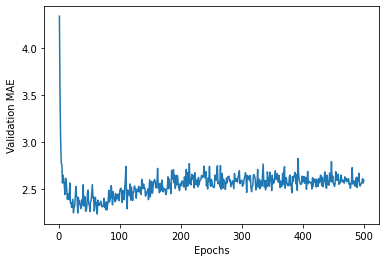

In [30]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

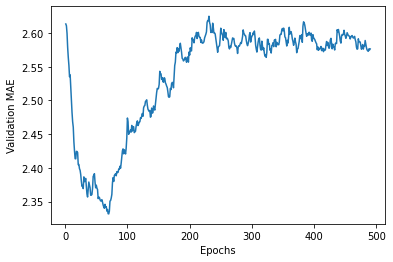

In [31]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [32]:
# now train model on full dataset accordingly